In [1]:

import ee
import geemap
import geopandas as gpd

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Get the project root directory (one level up from current directory)
project_root = Path.cwd().parent

In [4]:
GOOGLE_CLOUD_PROJECT = "ee-ciut"

ee.Authenticate()

ee.Initialize(project=GOOGLE_CLOUD_PROJECT)

In [5]:
target_partidos = ["La Plata", "Berisso", "Ensenada"]
gaul_l2 = ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L2")

municipalities = (
    gaul_l2.filter(ee.Filter.eq("gaul0_name", "Argentina"))
    .filter(ee.Filter.eq("gaul1_name", "Buenos Aires"))
    .filter(ee.Filter.inList("gaul2_name", target_partidos))
)

basins_path = project_root / "data" / "dipsoh_cuencas.geojson"
basins_gdf = gpd.read_file(basins_path)

basins_ee = geemap.geopandas_to_ee(basins_gdf)
intersecting_basins = basins_ee.filterBounds(municipalities.geometry())
aoi = intersecting_basins.geometry()

In [6]:
aoi_gdf = geemap.ee_to_gdf(intersecting_basins)

In [7]:
worldpop = (
    ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq("system:index", "ARG_2010"))
    .first()
    .clip(aoi)
)

hrsl = (
    ee.ImageCollection("projects/sat-io/open-datasets/hrsl/hrslpop")
    .median()
    .clip(aoi)
)

ghsl = ee.Image("JRC/GHSL/P2023A/GHS_POP/2010").clip(aoi)
ghsl = ghsl.updateMask(ghsl.gt(0))

In [8]:
census_2010_path = project_root / "data" / "Radios 2010 v2025-1.parquet"
census_2010_gdf = gpd.read_parquet(census_2010_path)

# First ensure they're in the same projection
if census_2010_gdf.crs != aoi_gdf.crs:
    aoi_gdf = aoi_gdf.to_crs(census_2010_gdf.crs)

# Perform the spatial clip
clipped_census = gpd.clip(census_2010_gdf, aoi_gdf)
# First do the type conversions on the GeoDataFrame
clipped_census = clipped_census[["COD_2010", "B_POB_TOT", "geometry"]]
clipped_census["COD_2010"] = clipped_census["COD_2010"].astype(str)
clipped_census["B_POB_TOT"] = clipped_census["B_POB_TOT"].astype(int)

# Then convert to Earth Engine
census_2010_ee = geemap.geopandas_to_ee(clipped_census)

In [9]:
# Create map and center on AOI
Map = geemap.Map(basemap="CartoDB.Positron")
Map.centerObject(aoi, 8)

Map.addLayer(
    worldpop,
    {
        "bands": ["population"],
        "min": 0.0,
        "max": 50.0,
        "palette": ["24126c", "1fff4f", "d4ff50"],
    },
    "WorldPop Population (2010, 100m)",
    shown=False,  # Start with layer off
)

Map.addLayer(
    hrsl,
    {
        "min": 0.0,
        "max": 500.0,
        "palette": ["24126c", "1fff4f", "d4ff50"],
    },
    "HRSL (2016, 30m)",
    shown=False,  # Start with layer off
)

Map.addLayer(
    ghsl,
    {
        "min": 0.0,
        "max": 100.0,
        "palette": [
            "000004",
            "320A5A",
            "781B6C",
            "BB3654",
            "EC6824",
            "FBB41A",
            "FCFFA4",
        ],
    },
    "GHSL (2010, 100m)",
    shown=False,  # Start with layer off
)

vis_params = {
    "color": "000000",  # Black border
    "colorOpacity": 1,
    "width": 1,  # Thinner border for census tracts
    "lineType": "solid",
    "fillColorOpacity": 0.8,  # Slightly more opaque for better visibility
}

# Using a population-appropriate color palette (from low to high population)
palette = [
    "#f7fbff",
    "#deebf7",
    "#c6dbef",
    "#9ecae1",
    "#6baed6",
    "#4292c6",
    "#2171b5",
    "#08519c",
    "#08306b",
]

Map.add_styled_vector(
    census_2010_ee,
    column="B_POB_TOT",
    palette=palette,
    layer_name="Censo 2010",
    **vis_params,
)

Map

Map(center=[-35.23620217745599, -57.97610800815036], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
worldpop_fc = census_2010_ee.map(lambda feature:
    feature.set('pop_worldpop', 
        ee.Number(worldpop.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=100,
            maxPixels=1e13
        ).get(worldpop.bandNames().get(0))).round()
    )
)

hrsl_fc = census_2010_ee.map(lambda feature:
    feature.set('pop_hrsl', 
        ee.Number(hrsl.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=30,
            maxPixels=1e13
        ).get(hrsl.bandNames().get(0))).round()
    )
)

ghsl_fc = census_2010_ee.map(lambda feature:
    feature.set('pop_ghsl', 
        ee.Number(ghsl.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=100,
            maxPixels=1e13
        ).get(ghsl.bandNames().get(0))).round()
    )
)

worldpop_gdf = geemap.ee_to_gdf(worldpop_fc)
hrsl_gdf = geemap.ee_to_gdf(hrsl_fc)
ghsl_gdf = geemap.ee_to_gdf(ghsl_fc)

In [14]:
combined_gdf = worldpop_gdf.merge(hrsl_gdf[['COD_2010', 'pop_hrsl']], on='COD_2010')
combined_gdf = combined_gdf.merge(ghsl_gdf[['COD_2010', 'pop_ghsl']], on='COD_2010')

In [30]:
combined_gdf

,geometry,B_POB_TOT,COD_2010,pop_worldpop,pop_hrsl,pop_ghsl
0,"POLYGON ((-57.54857 -35.69416, -57.54468 -35.6...",69,062170903,137,242,61
1,"MULTIPOLYGON (((-57.7096 -35.64613, -57.70537 ...",72,062170904,18,38,5
2,"POLYGON ((-57.6892 -35.65125, -57.6889 -35.651...",54,062170901,62,297,45
3,"POLYGON ((-57.76162 -35.50343, -57.75225 -35.5...",85,062170801,48,413,99
4,"POLYGON ((-57.79748 -35.44543, -57.7962 -35.44...",140,066550105,35,341,124
...,...,...,...,...,...,...
1599,"POLYGON ((-57.75607 -35.07322, -57.75494 -35.0...",635,065050210,127,497,553
1600,"POLYGON ((-57.76 -35.05487, -57.75893 -35.0555...",356,065050204,654,846,491
1601,"POLYGON ((-57.73967 -35.02179, -57.73752 -35.0...",288,065050205,252,828,324
1602,"MULTIPOLYGON (((-57.75421 -34.97238, -57.75385...",75,065050202,246,154,54


In [15]:
def calculate_signed_percentage_error(actual, predicted, epsilon=1):
    return np.mean((predicted - actual) / (actual + epsilon)) * 100

# Calculate signed percentage error for each population dataset
worldpop_spe = calculate_signed_percentage_error(combined_gdf["B_POB_TOT"], combined_gdf["pop_worldpop"])
hrsl_spe = calculate_signed_percentage_error(combined_gdf["B_POB_TOT"], combined_gdf["pop_hrsl"])
ghsl_spe = calculate_signed_percentage_error(combined_gdf["B_POB_TOT"], combined_gdf["pop_ghsl"])


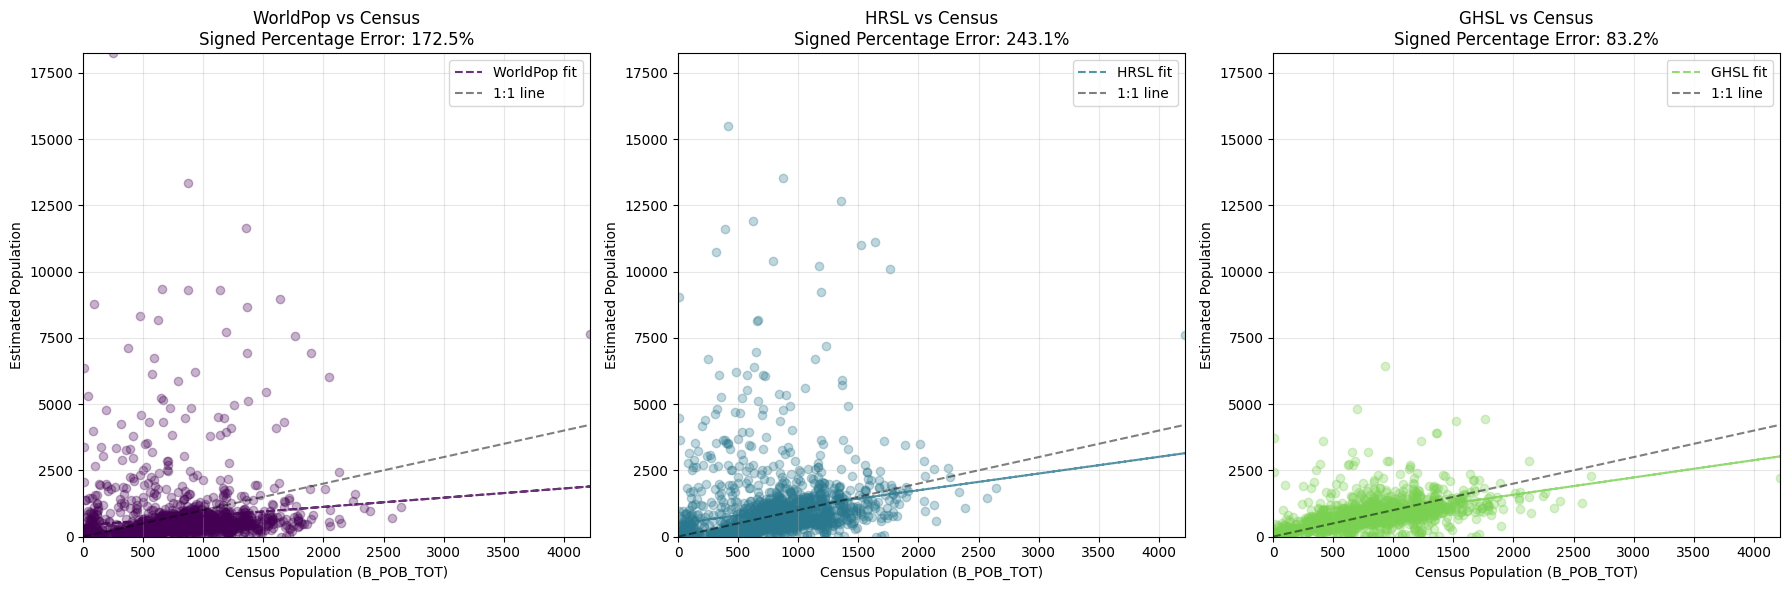

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [ax1, ax2, ax3]
colors = plt.cm.viridis(np.linspace(0, 0.8, 3))
max_x = combined_gdf["B_POB_TOT"].max()  # Use the original column, not census_pop
max_y = max(
    combined_gdf["pop_worldpop"].max(),
    combined_gdf["pop_hrsl"].max(),
    combined_gdf["pop_ghsl"].max()
)
datasets = [
    (combined_gdf["pop_worldpop"], "WorldPop", worldpop_spe, colors[0]),
    (combined_gdf["pop_hrsl"], "HRSL", hrsl_spe, colors[1]),
    (combined_gdf["pop_ghsl"], "GHSL", ghsl_spe, colors[2]),
]
for ax, (data, label, spe, color) in zip(axes, datasets):
    ax.scatter(combined_gdf["B_POB_TOT"], data, alpha=0.3, color=color)
    # Filter out zeros if you're fitting a line
    mask = combined_gdf["B_POB_TOT"] > 0
    z = np.polyfit(combined_gdf["B_POB_TOT"][mask], data[mask], 1)
    p = np.poly1d(z)
    ax.plot(
        combined_gdf["B_POB_TOT"], p(combined_gdf["B_POB_TOT"]), "--", color=color, alpha=0.8, label=f"{label} fit"
    )
    ax.plot([0, max_x], [0, max_x], "k--", alpha=0.5, label="1:1 line")
    ax.set_xlabel("Census Population (B_POB_TOT)")
    ax.set_ylabel("Estimated Population")
    # Update title to show SPE instead of MAPE
    ax.set_title(f"{label} vs Census\nSigned Percentage Error: {spe:.1f}%")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    ax.legend()
plt.tight_layout()
plt.show()

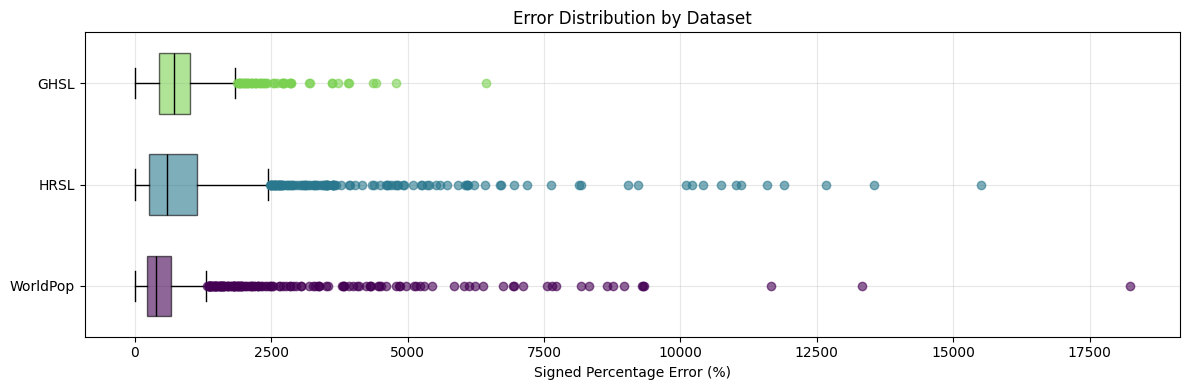

In [31]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Create boxplot with all datasets
bp = ax.boxplot([data for data, _, _, _ in datasets], 
                patch_artist=True, 
                widths=0.6,
                labels=[label for _, label, _, _ in datasets],
                vert=False)  # Make it horizontal

# Get colors for each box
colors = [color for _, _, _, color in datasets]

# Customize boxplot colors - only fill and outliers
for box, color in zip(bp['boxes'], colors):
    box.set(facecolor=color, alpha=0.6)
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1)
for median in bp['medians']:
    median.set(color='black', linewidth=1)
for flier, color in zip(bp['fliers'], colors):
    flier.set(markerfacecolor=color, markeredgecolor=color, alpha=0.6)

# Customize plot
ax.set_xlabel("Signed Percentage Error (%)")
ax.set_title("Error Distribution by Dataset")
ax.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
from pyproj import Geod

# Create a Geod object for area calculations
geod = Geod(ellps="WGS84")

# Calculate area in square meters
combined_gdf["area"] = combined_gdf["geometry"].apply(
    lambda geom: abs(geod.geometry_area_perimeter(geom)[0])
)

In [33]:
combined_gdf.head()

,geometry,B_POB_TOT,COD_2010,pop_worldpop,pop_hrsl,pop_ghsl,area
0,"POLYGON ((-57.54857 -35.69416, -57.54468 -35.6...",69,062170903,137,242,61,9.118661e+07
1,"MULTIPOLYGON (((-57.7096 -35.64613, -57.70537 ...",72,062170904,18,38,5,3.195173e+07
2,"POLYGON ((-57.6892 -35.65125, -57.6889 -35.651...",54,062170901,62,297,45,1.218737e+08
3,"POLYGON ((-57.76162 -35.50343, -57.75225 -35.5...",85,062170801,48,413,99,1.830563e+08
4,"POLYGON ((-57.79748 -35.44543, -57.7962 -35.44...",140,066550105,35,341,124,1.777222e+08


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mapclassify import NaturalBreaks
import matplotlib.colors as colors

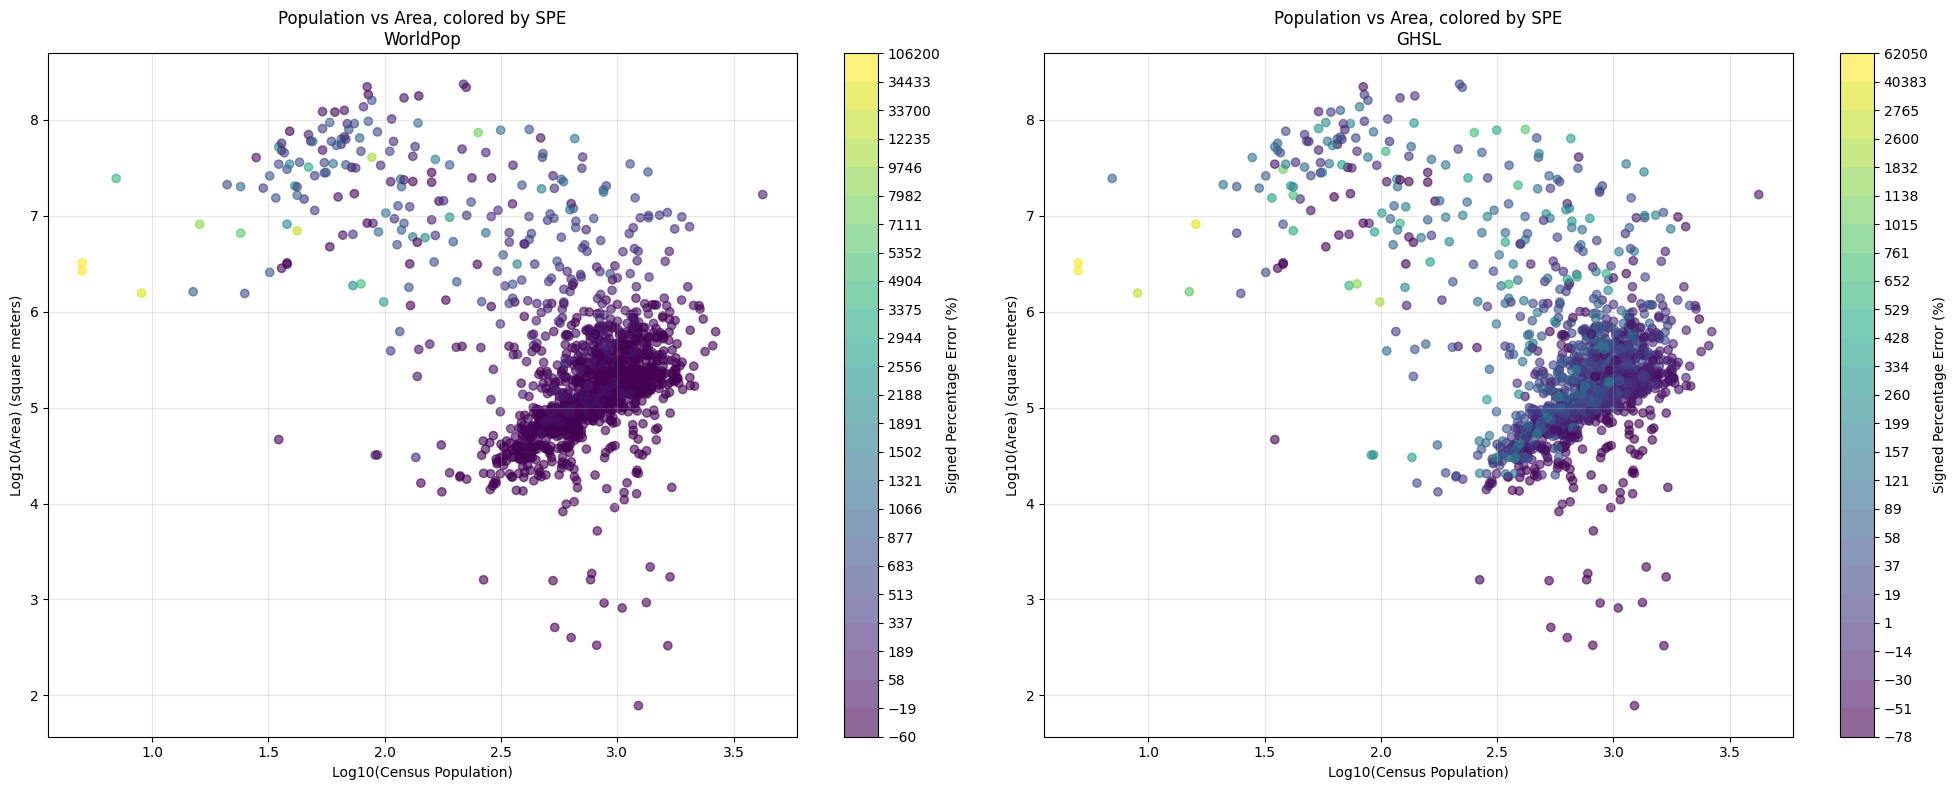

In [36]:
# Initialize the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Function to calculate signed percentage error for each row
def calculate_spe(row, actual_col, predicted_col, epsilon=1):
    return ((row[predicted_col] - row[actual_col]) / (row[actual_col] + epsilon)) * 100

# Calculate SPE for each dataset
combined_gdf['worldpop_spe'] = combined_gdf.apply(lambda row: calculate_spe(row, 'B_POB_TOT', 'pop_worldpop'), axis=1)
combined_gdf['ghsl_spe'] = combined_gdf.apply(lambda row: calculate_spe(row, 'B_POB_TOT', 'pop_ghsl'), axis=1)

# Function to create scatter plot
def create_scatter_plot(ax, data, spe_col, title):
    # Calculate Fisher breaks for SPE
    classifier = NaturalBreaks(data[spe_col], k=25)
    breaks = classifier.bins
    
    # Create a discrete colormap
    cmap = plt.cm.viridis
    norm = colors.BoundaryNorm(breaks, cmap.N)
    
    # Create the scatter plot
    scatter = ax.scatter(
        np.log10(data["B_POB_TOT"]),
        np.log10(data["area"]),
        c=data[spe_col],
        cmap=cmap,
        norm=norm,
        alpha=0.6,
    )
    
    # Add colorbar with break points
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Signed Percentage Error (%)")
    cbar.set_ticks(breaks)
    
    # Set labels and title
    ax.set_xlabel("Log10(Census Population)")
    ax.set_ylabel("Log10(Area) (square meters)")
    ax.set_title(f"Population vs Area, colored by SPE\n{title}")
    
    # Add grid
    ax.grid(True, alpha=0.3)

# Create plots for WorldPop and GHSL
create_scatter_plot(ax1, combined_gdf, 'worldpop_spe', "WorldPop")
create_scatter_plot(ax2, combined_gdf, 'ghsl_spe', "GHSL")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Define years to process
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030]

# Create a list to hold all images with year as property
ghsl_images = []

# Create images with year property already set
for year in years:
    image_path = f"JRC/GHSL/P2023A/GHS_POP/{year}"
    img = ee.Image(image_path).clip(aoi)

    # First identify the band name by printing the first image
    if year == 2000:
        print(f"Available bands: {img.bandNames().getInfo()}")

    img = img.updateMask(img.gt(0))
    # Set year as a property directly
    img = img.set("year", ee.Number(year))
    ghsl_images.append(img)

# Create an ImageCollection from the list of images
ghsl_collection = ee.ImageCollection(ghsl_images)

# Calculate zonal statistics for all years at once
features = intersecting_basins.toList(intersecting_basins.size())


# This creates a FeatureCollection with all statistics
def calculate_stats(feature):
    feature = ee.Feature(feature)

    # Process each year
    for year in years:
        # Filter collection to get image for this year
        img = ghsl_collection.filter(ee.Filter.eq("year", year)).first()

        # Get the correct band name - will be first band in the image
        band_name = ee.Image(img).bandNames().get(0)

        # Calculate sum for this feature/basin
        stats = img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=100,
            maxPixels=1e13,  # Increase for large areas
        )

        # Get the population value using the dynamic band name
        pop_value = ee.Number(stats.get(band_name)).round()

        # Set as property with year in the name
        feature = feature.set(f"pop_{year}", pop_value)

    return feature


# Server-side mapping function to process all features
result_fc = ee.FeatureCollection(features.map(lambda f: calculate_stats(ee.Feature(f))))


# Convert directly to GeoDataFrame for inspection
def inspect_result():
    """Convert FeatureCollection to GeoDataFrame and inspect"""
    try:
        # Directly convert to GeoDataFrame
        result_gdf = geemap.ee_to_gdf(result_fc)

        return result_gdf
    except Exception as e:
        print(f"Error converting to GeoDataFrame: {e}")

        # Fallback: Try to get at least one feature to understand the structure
        try:
            first_feature = result_fc.first().getInfo()
            print("\nFirst feature properties:")
            print(first_feature["properties"])

            # Check if we got band name wrong
            band_names = ghsl_collection.first().bandNames().getInfo()
            print(f"\nActual band names: {band_names}")
        except Exception as e2:
            print(f"Further inspection failed: {e2}")

        return None


# Inspect the result
result_gdf = inspect_result()

In [ ]:
def create_tidy_geodataframe(result_gdf):
    """
    Convert the wide-format GeoDataFrame to a tidy (long) format with:
    - nombre: Combined name from nombre and sucuenca_n columns
    - year: Year of population estimate
    - pob: Population value
    """
    # First, create a clean nombre column that combines nombre and sucuenca_n
    result_gdf["nombre_clean"] = result_gdf.apply(
        lambda row: (
            f"{row['nombre']}, {row['sucuenca_n']}"
            if pd.notna(row["sucuenca_n"])
            else row["nombre"]
        ),
        axis=1,
    )

    # Identify population columns by prefix
    pop_columns = [col for col in result_gdf.columns if col.startswith("pop_")]

    # List of columns to keep (non-population columns)
    keep_columns = ["geometry", "nombre_clean"]

    # Create an empty list to store dataframes for each year
    dfs = []

    # Process each year's population column
    for pop_col in pop_columns:
        # Extract year from column name
        year = int(pop_col.split("_")[1])

        # Create a copy of the DF with only required columns
        year_df = result_gdf[keep_columns + [pop_col]].copy()

        # Rename population column to 'pob'
        year_df = year_df.rename(columns={pop_col: "pob"})

        # Add year column
        year_df["year"] = year

        # Append to list of dataframes
        dfs.append(year_df)

    # Concatenate all dataframes
    tidy_gdf = pd.concat(dfs, ignore_index=True)

    # Reorder columns for clarity
    tidy_gdf = tidy_gdf[["geometry", "nombre_clean", "year", "pob"]]

    # Rename nombre_clean to nombre
    tidy_gdf = tidy_gdf.rename(columns={"nombre_clean": "nombre"})

    return tidy_gdf


# Apply the function to convert to tidy format
tidy_gdf = create_tidy_geodataframe(result_gdf)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tidy_gdf is already loaded

# Group by nombre and year, and calculate the sum of pob for each group
grouped = tidy_gdf.groupby(["nombre", "year"])["pob"].sum().reset_index()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique nombres for colors
nombres = grouped["nombre"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(nombres)))

# Plot each nombre as a separate line
for i, nombre in enumerate(nombres):
    data = grouped[grouped["nombre"] == nombre]
    ax.plot(
        data["year"],
        data["pob"],
        marker="o",
        linestyle="-",
        label=nombre,
        color=colors[i],
    )

# Add labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Population (pob)")
ax.set_title("Population by Year for Different Locations")

# Add legend (if there are many locations, you may want to adjust the placement)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()